In [1]:
import pandas as pd
import os
from datetime import datetime as dt
import wrangle
import re
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (12,10)
alpha =.05

### Acquire

In [2]:
df = wrangle.get_combined_df()
df.head(3)

,ercot_load,dow,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,...,vc_precip,vc_windgust,vc_windspeed,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00-06:00,7931.241900,Friday,1,1,47.3,41.2,43.2,85.37,0.0,27.5,...,0.0,24.2,16.1,360.0,1027.7,98.7,9.9,0.0,NaN,0
2010-01-01 01:00:00-06:00,7775.456846,Friday,1,1,46.8,39.9,41.4,81.38,0.0,24.2,...,0.0,26.5,15.1,350.0,1028.1,98.6,9.9,0.0,NaN,0
2010-01-01 02:00:00-06:00,7704.815982,Friday,1,1,45.0,37.1,39.6,81.24,0.0,28.9,...,0.0,31.1,21.9,350.0,1028.8,98.6,9.9,0.0,NaN,0


### ERCOT load and Weather Exploration

In [3]:
# split data into train and test datasets, train 2010-2017 and test 2018-2022

train = df[:'2017']
test = df['2018':]

In [4]:
explore=train.copy()

In [5]:
explore = explore.drop(columns=['dow'])


In [6]:
# explore['hour'] = explore['hour'].astype('int')
# explore['dow'] = explore['dow'].astype('int')

In [7]:
explore.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70128 entries, 2010-01-01 00:00:00-06:00 to 2017-12-31 23:00:00-06:00
Data columns (total 59 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ercot_load           70128 non-null  float64
 1   is_weekday           70128 non-null  int64  
 2   is_obs_holiday       70128 non-null  int64  
 3   hs_temp              70128 non-null  float64
 4   hs_feelslike         70128 non-null  float64
 5   hs_dew               70128 non-null  float64
 6   hs_humidity          70128 non-null  float64
 7   hs_precip            70128 non-null  float64
 8   hs_windgust          13765 non-null  float64
 9   hs_windspeed         70128 non-null  float64
 10  hs_winddir           70128 non-null  float64
 11  hs_sealevelpressure  70028 non-null  float64
 12  hs_cloudcover        70128 non-null  float64
 13  hs_visibility        70128 non-null  float64
 14  hs_solarradiation    70128 non-null  fl

### Heat Map

<AxesSubplot:ylabel='datetime'>

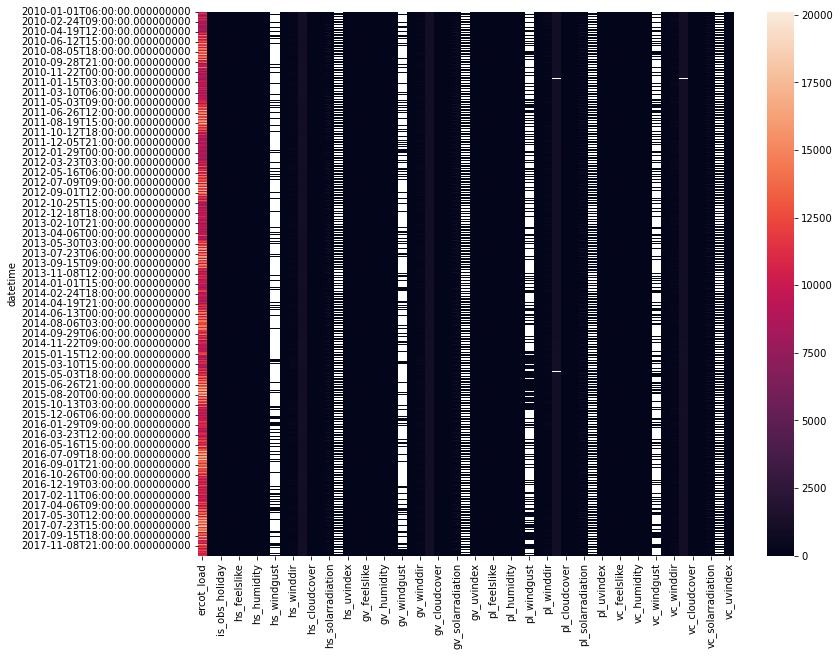

In [8]:
sns.heatmap(explore)

In [9]:
explore['mean_temp']=((explore['hs_temp'] + explore['vc_temp'] + explore['pl_temp'] + explore['gv_temp'])/4)

In [10]:
explore['mean_feelslike']=((explore['hs_feelslike'] + explore['vc_feelslike'] + explore['pl_feelslike'] + explore['gv_feelslike'])/4)

In [11]:
explore['mean_humidity']=((explore['hs_humidity'] + explore['vc_humidity'] + explore['pl_humidity'] + explore['gv_humidity'])/4)

In [12]:
explore.head(1)

,ercot_load,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,hs_windspeed,...,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex,mean_temp,mean_feelslike,mean_humidity
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00-06:00,7931.2419,1,1,47.3,41.2,43.2,85.37,0.0,27.5,15.1,...,360.0,1027.7,98.7,9.9,0.0,NaN,0,49.025,44.4,84.2


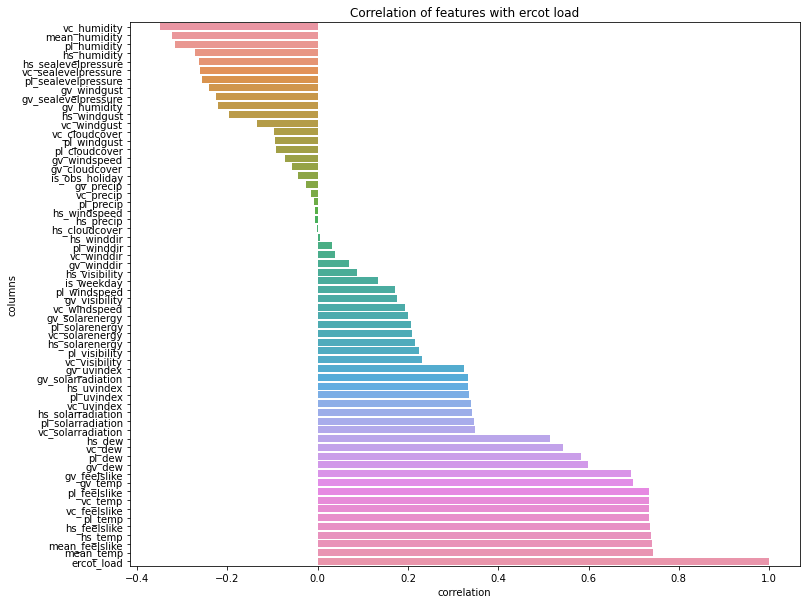

In [13]:
correlation = pd.DataFrame()
correlation['columns'] = explore.corrwith(explore['ercot_load'],method='spearman').index
correlation['correlation'] = explore.corrwith(explore['ercot_load'],method='spearman').values
sns.barplot(data=correlation.sort_values('correlation'), x='correlation', y='columns')
plt.title('Correlation of features with ercot load')
plt.show()

In [14]:
pd.set_option('display.max_rows', None)
explore.corrwith(explore['ercot_load'],method='spearman').sort_values()

vc_humidity           -0.348257
mean_humidity         -0.323051
pl_humidity           -0.316161
hs_humidity           -0.270534
hs_sealevelpressure   -0.262428
vc_sealevelpressure   -0.260937
pl_sealevelpressure   -0.255291
gv_windgust           -0.241468
gv_sealevelpressure   -0.225634
gv_humidity           -0.220918
hs_windgust           -0.195618
vc_windgust           -0.134975
vc_cloudcover         -0.096835
pl_windgust           -0.094215
pl_cloudcover         -0.091208
gv_windspeed          -0.072712
gv_cloudcover         -0.057037
is_obs_holiday        -0.042854
gv_precip             -0.026512
vc_precip             -0.015054
pl_precip             -0.008226
hs_windspeed          -0.006393
hs_precip             -0.004979
hs_cloudcover         -0.000717
hs_winddir             0.005570
pl_winddir             0.031215
vc_winddir             0.038014
gv_winddir             0.070544
hs_visibility          0.086316
is_weekday             0.134722
pl_windspeed           0.172156
gv_visib

**Notes:** 
- The strongest **positive** correlation between ercot load occurs with mean_temp, and mean_feelslike. **(~.74)**
- The strongest **negative** correlation between ercot load occurs with vc_humidity, pl_humidity, and hs_humidity **(~-.30)**


**Initial hypothesis testing to occur on temperature and feels like**

In [15]:
explore.head(1)

,ercot_load,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,hs_windspeed,...,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex,mean_temp,mean_feelslike,mean_humidity
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00-06:00,7931.2419,1,1,47.3,41.2,43.2,85.37,0.0,27.5,15.1,...,360.0,1027.7,98.7,9.9,0.0,NaN,0,49.025,44.4,84.2


### Temperature and ERCOT Load

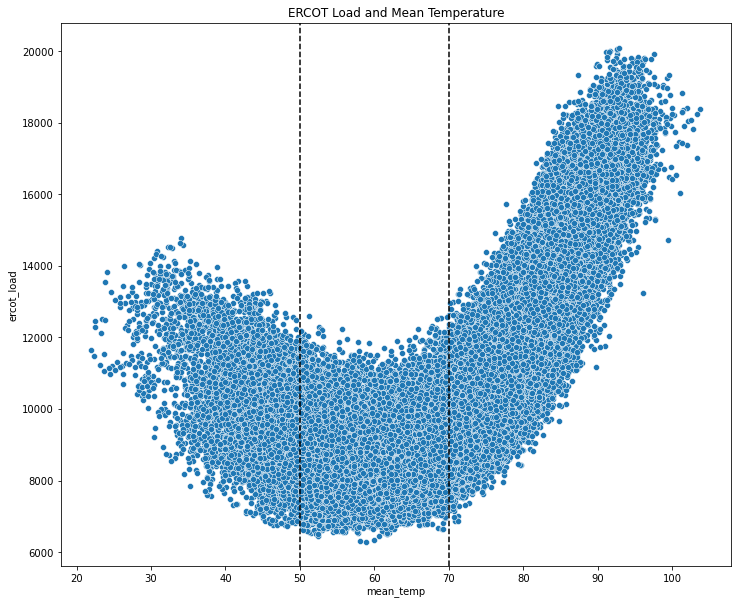

In [63]:
sns.scatterplot(data=explore, x='mean_temp',y='ercot_load')
plt.axvline(x=(50),color='black',ls='--')
plt.axvline(x=(70),color='black',ls='--')
plt.title("ERCOT Load and Mean Temperature")
plt.show()

### Hypothesis Testing

- Null Hypothesis: There is no relationship between ercot load and temperature.
- Alternative Hypothesis: There is a relationship between ercot load and temperature.

In [17]:
less_50 = explore[explore.mean_temp <=50]
mid_temp = explore[(explore.mean_temp>50)& (explore.mean_temp<70)]
greater_70 = explore[explore.mean_temp >=70]

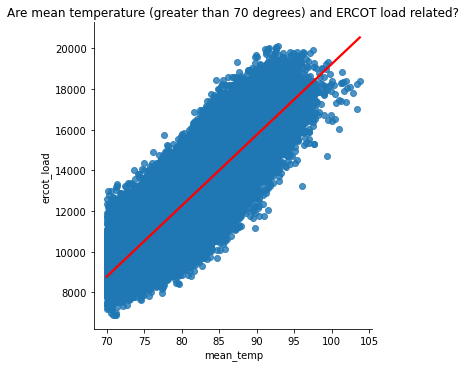

In [18]:
sns.lmplot(data=greater_70, x='mean_temp',y='ercot_load',line_kws={'color':'red'})
plt.title("Are mean temperature (greater than 70 degrees) and ERCOT load related?")
plt.show()

In [19]:
r, p = stats.spearmanr(greater_70.ercot_load, greater_70.mean_temp)
r, p

(0.8273795989163407, 0.0)

In [20]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


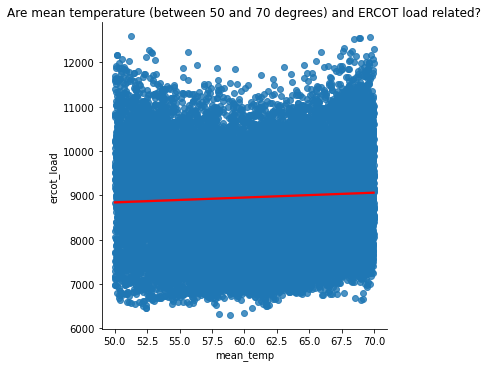

In [21]:
sns.lmplot(data=mid_temp, x='mean_temp',y='ercot_load',line_kws={'color':'red'})
plt.title("Are mean temperature (between 50 and 70 degrees) and ERCOT load related?")
plt.show()

In [22]:
r, p = stats.spearmanr(mid_temp.ercot_load, mid_temp.mean_temp)
r, p

(0.07272942335979242, 9.462527286479247e-28)

In [23]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


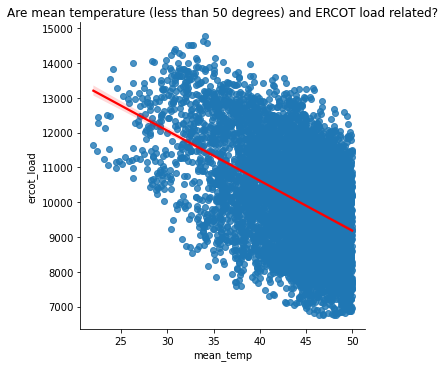

In [24]:
sns.lmplot(data=less_50, x='mean_temp',y='ercot_load',line_kws={'color':'red'})
plt.title("Are mean temperature (less than 50 degrees) and ERCOT load related?")
plt.show()

In [25]:
r, p = stats.spearmanr(less_50.ercot_load, less_50.mean_temp)
r, p

(-0.43770741903723387, 3.559188791408997e-287)

In [26]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


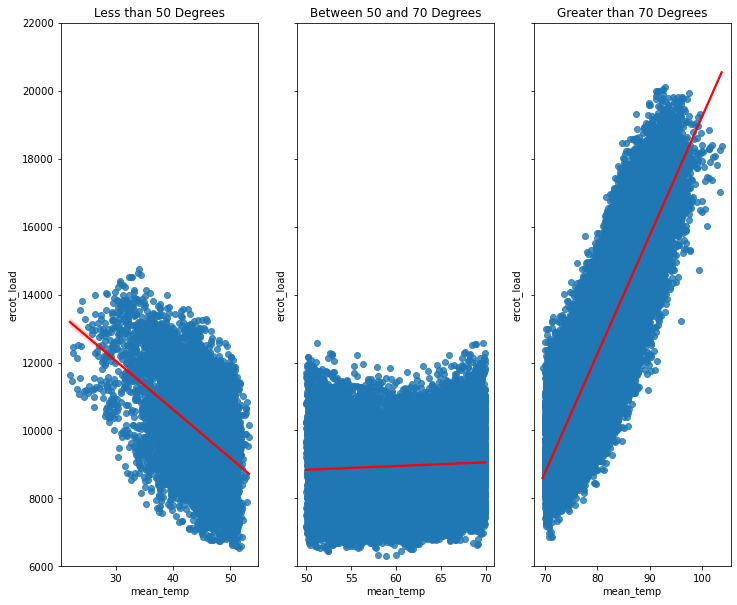

In [93]:

plt.subplot(131)
g=sns.regplot(data=less_50, x='mean_temp',y='ercot_load',line_kws={'color':'red'})
plt.title('Less than 50 Degrees')
g.set_ylim(6000, 22000)

plt.subplot(132)
g=sns.regplot(data=mid_temp, x='mean_temp',y='ercot_load',line_kws={'color':'red'})
plt.title('Between 50 and 70 Degrees')
g.set_ylim(6000, 22000)
g.set(yticklabels=[])

plt.subplot(133)
g=sns.regplot(data=greater_70, x='mean_temp',y='ercot_load',line_kws={'color':'red'})
plt.title('Greater than 70 Degrees')
g.set_ylim(6000, 22000)
g.set(yticklabels=[])
plt.show()

**Notes:** We can visually see the relationship between temperature like and ERCOT load, depicted by the U shape. To further test this, we ran Spearman's correlation testing with three different temperature ranges. 

- Less than 50 degrees
- Between 50 and 70 degrees
- Greater than 70 degrees

The strongest relationship between temperature and ERCOT load is when it is greater than 70 degrees with a correlation coefficient of .83. There is a moderate negative relationship between temperatures that are less than 50 degress with a correlation coefficient of -.44. While, the mid-range temperatures are not as strongly correlated, all three ranges of temperatures are related to ERCOT load in regards to statistical significance.

### Feels like and ERCOT Load

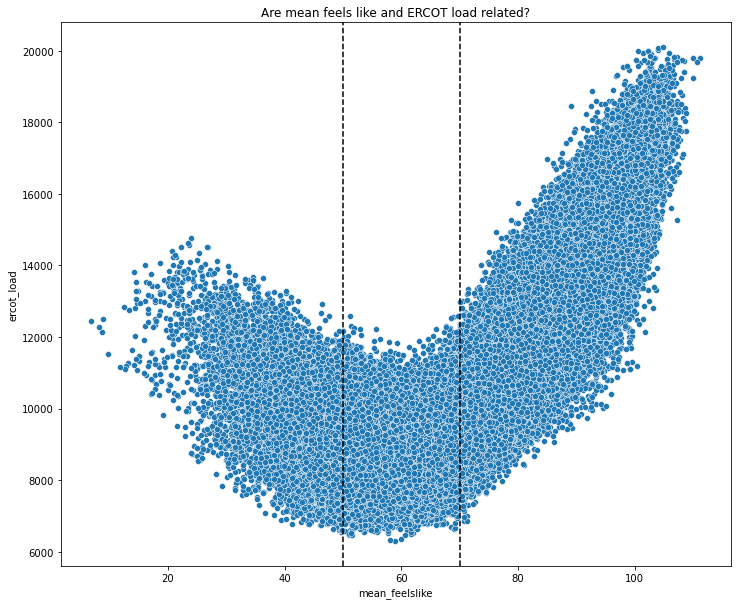

In [61]:
sns.scatterplot(data=explore, x='mean_feelslike',y='ercot_load')
plt.title("Are mean feels like and ERCOT load related?")
plt.axvline(x=(50),color='black',ls='--')
plt.axvline(x=(70),color='black',ls='--')
plt.show()

In [28]:
less_50 = explore[explore.mean_feelslike<=50]
mid_feelslike= explore[(explore.mean_feelslike>50)& (explore.mean_feelslike<70)]
greater_70 = explore[explore.mean_feelslike>=70]

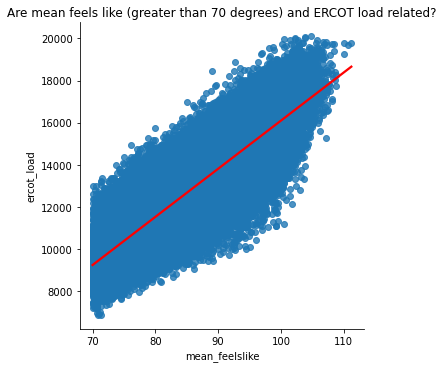

In [29]:
sns.lmplot(data=greater_70, x='mean_feelslike',y='ercot_load',line_kws={'color':'red'})
plt.title("Are mean feels like (greater than 70 degrees) and ERCOT load related?")
plt.show()

In [30]:
r, p = stats.spearmanr(greater_70.ercot_load, greater_70.mean_feelslike)
r, p

(0.8175146840379727, 0.0)

In [31]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


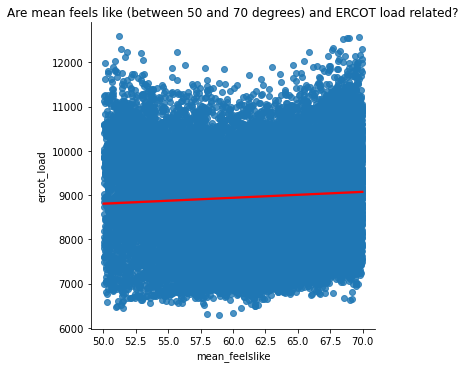

In [32]:
sns.lmplot(data=mid_feelslike, x='mean_feelslike',y='ercot_load',line_kws={'color':'red'})
plt.title("Are mean feels like (between 50 and 70 degrees) and ERCOT load related?")
plt.show()

In [33]:
r, p = stats.spearmanr(mid_feelslike.ercot_load, mid_feelslike.mean_feelslike)
r, p

(0.08289328205452048, 1.521342834954172e-34)

In [34]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


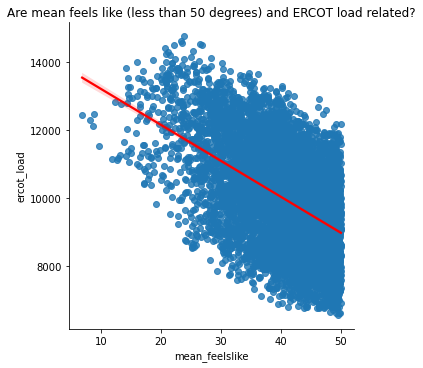

In [35]:
sns.lmplot(data=less_50, x='mean_feelslike',y='ercot_load',line_kws={'color':'red'})
plt.title("Are mean feels like (less than 50 degrees) and ERCOT load related?")
plt.show()

In [36]:
r, p = stats.spearmanr(less_50.ercot_load, less_50.mean_feelslike)
r, p

(-0.461010195441998, 0.0)

In [37]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


**Notes:** We can visually see the relationship between mean feels like and ERCOT load, depicted by the U shape. To further test this, we ran Spearman's correlation testing with three different ranges of feels like temperatures. 

- Less than 50 degrees
- Between 50 and 70 degrees
- Greater than 70 degrees

The strongest relationship between feels like and ERCOT load is when it feels like greater than 70 degrees with a correlation coefficient of .82. There is a moderate negative relationship between temperatures that fee like less than 50 degress with a correlation coefficient of -.46. While, the mid-range feels like temperatures are not as strongly correlated, all three ranges of temperatures are related to ERCOT load in regards to statistical significance.

### Humidity and ERCOT LOAD

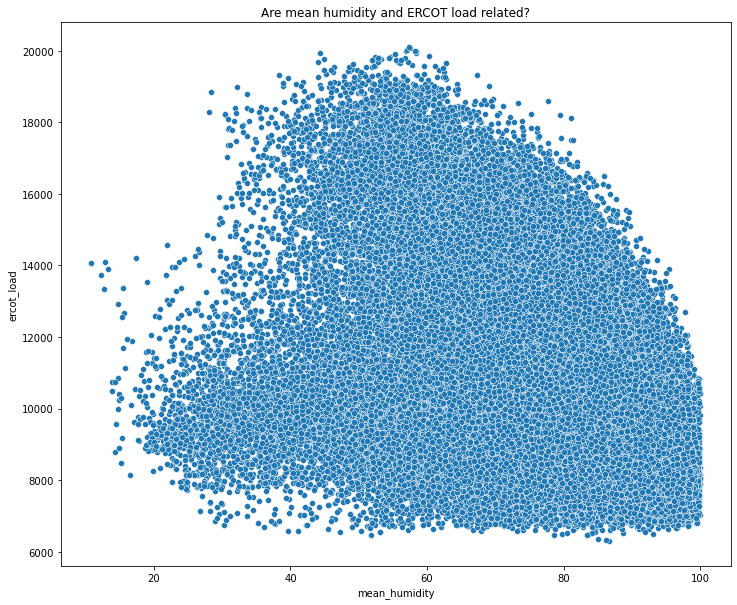

In [41]:
sns.scatterplot(data=explore, x='mean_humidity',y='ercot_load')
plt.title("Are mean humidity and ERCOT load related?")
plt.show()

In [42]:
r, p = stats.spearmanr(explore.ercot_load, explore.mean_humidity)
r, p

(-0.32305121261403674, 0.0)